Copyright 2021 The TensorFlow Similarity Authors.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

In [4]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [5]:
from tensorflow_similarity.augmenters import SimCLRAugmenter
from tensorflow_similarity.losses import SimCLRLoss, SimSiamLoss, Barlow
from tensorflow_similarity.models import ContrastiveModel
from tensorflow_similarity.samplers import SingleShotMemorySampler
from tensorflow_similarity.training_metrics import encoder_std  # # siam siam metric
from tensorflow_similarity.visualization import visualize_views

In [6]:
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

2021-11-13 05:57:02.507880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 05:57:02.518746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 05:57:02.519475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Dataset

## Loading

In [7]:
(x_train, y_raw_train), (x_test, y_raw_test) = keras.datasets.cifar10.load_data()
print("x_train", x_train.shape, "x_test", x_test.shape)
y_train = keras.utils.to_categorical(y_raw_train, 10)
y_test = keras.utils.to_categorical(y_raw_test, 10)
print("y_train", y_train.shape, "y_test", y_test.shape)

x_train (50000, 32, 32, 3) x_test (10000, 32, 32, 3)
y_train (50000, 10) y_test (10000, 10)


In [8]:
IMG_SIZE = 32
BATCH_SIZE = 128
INIT_LR = 0.03
PRE_TRAIN_EPOCHS = 200
STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
WEIGHT_DECAY = 0.0005
DIM = 2048

In [9]:
train_augmenter = SimCLRAugmenter(IMG_SIZE, IMG_SIZE, is_training=True)
sampler = SingleShotMemorySampler(
    x_train,
    examples_per_batch=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    augmenter=train_augmenter,
    num_augmentations_per_example=2,
)


The initial batch size is 128 (128 classes * 1 examples per class) with 2 augmenters


2021-11-13 05:57:03.229646: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-13 05:57:03.230870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 05:57:03.231671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 05:57:03.232342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

2021-11-13 05:57:05.430264: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


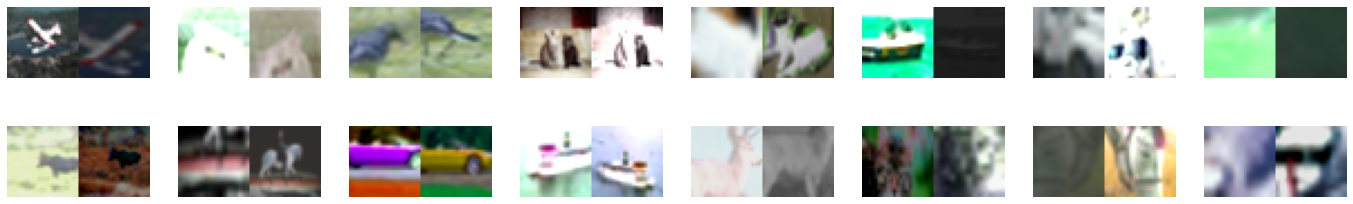

In [10]:
visualize_views(views=sampler.generate_batch(0), num_imgs=16, views_per_col=8)

# Models

## Backbone 

In [11]:
!wget -q https://git.io/JYx2x -O resnet_cifar10_v2.py

In [12]:
import resnet_cifar10_v2

# resnet params
N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1

In [13]:
def get_backbone(img_size, dim, activation="relu", trainable=True):

    inputs = layers.Input((img_size, img_size, 3))
    # ResNet expects [-1,1], but our augmented images are [0,1]
    x = layers.Rescaling(scale=2, offset=-1)(inputs)
    x = resnet_cifar10_v2.stem(x)
    x = resnet_cifar10_v2.learner(x, NUM_BLOCKS)
    o = layers.GlobalAveragePooling2D(name="backbone_pool")(x)

    backbone = Model(inputs, o, name="encoder")
    return backbone


backbone = get_backbone(IMG_SIZE, DIM)
backbone.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 32, 32, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_166 (Conv2D)             (None, 32, 32, 16)   432         rescaling[0][0]                  
__________________________________________________________________________________________________
batch_normalization_164 (BatchN (None, 32, 32, 16)   64          conv2d_166[0][0]                 
____________________________________________________________________________________________

In [14]:
def get_projector(input_dim, dim, activation="relu", trainable=True):

    inputs = layers.Input((input_dim,))

    # Projection Head
    x = layers.Dense(
        dim,
        activation=activation,
        use_bias=False,
        kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
    )(inputs)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(
        dim,
        activation=activation,
        use_bias=False,
        kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
    )(x)
    x = layers.BatchNormalization()(x)

    o = layers.Dense(
        dim, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    o = layers.BatchNormalization()(x)

    projector = Model(inputs, o, name="encoder")
    return projector


projector = get_projector(input_dim=256, dim=DIM)
projector.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              524288    
_________________________________________________________________
batch_normalization_183 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4194304   
_________________________________________________________________
batch_normalization_184 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4194304   
Total params: 8,929,280
Trainable params: 8,921,088
Non-trainable params: 8,192
_____________________________________________

## Predictor model

In [15]:
def get_predictor(dim, hiddin_dim=512, activation="relu"):
    inputs = layers.Input(shape=(dim,))

    x = layers.Dense(
        hiddin_dim,
        activation=activation,
        use_bias=False,
        kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
    )(inputs)
    x = layers.BatchNormalization()(x)

    o = layers.Dense(dim)(x)
    projector = Model(inputs, o, name="predictor")
    return projector


predictor = get_predictor(DIM)
predictor.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1048576   
_________________________________________________________________
batch_normalization_185 (Bat (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              1050624   
Total params: 2,101,248
Trainable params: 2,100,224
Non-trainable params: 1,024
_________________________________________________________________


# Loss

In [16]:
# This loss is minimizing either the cosine distance or the angular
# distance and should be between [0, 4]
loss = SimSiamLoss(projection_type="cosine_distance")
# loss = Barlow()
metrics = [[encoder_std], []]

# Pre Training

In [17]:
contrastive_model = ContrastiveModel(
    backbone_model=backbone,
    projector_model=projector,
    predictor_model=predictor,
    method="simsiam",
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=50, restore_best_weights=True
)
# use sgd as optimizer with constant loss as recommende in the paper.
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=INIT_LR, decay_steps=PRE_TRAIN_EPOCHS * STEPS_PER_EPOCH
)
sgd = tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6)
contrastive_model.compile(optimizer=sgd, loss=loss, metrics=metrics)

In [18]:
contrastive_history = contrastive_model.fit(
    sampler, epochs=PRE_TRAIN_EPOCHS, callbacks=[early_stopping]
)

Epoch 1/200


2021-11-13 05:57:15.125478: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


390/390 [==============================] - 114s 277ms/step - loss: 0.1097 - output_1_encoder_std: 0.0221
Warmup complete
Epoch 2/200
390/390 [==============================] - 110s 279ms/step - loss: 0.0895 - output_1_encoder_std: 0.0221
Epoch 3/200
390/390 [==============================] - 109s 280ms/step - loss: 0.0852 - output_1_encoder_std: 0.0221
Epoch 4/200
390/390 [==============================] - 109s 278ms/step - loss: 0.0827 - output_1_encoder_std: 0.0221
Epoch 5/200
390/390 [==============================] - 109s 278ms/step - loss: 0.0801 - output_1_encoder_std: 0.0221
Epoch 6/200
390/390 [==============================] - 108s 277ms/step - loss: 0.0783 - output_1_encoder_std: 0.0221
Epoch 7/200
390/390 [==============================] - 107s 273ms/step - loss: 0.0767 - output_1_encoder_std: 0.0221
Epoch 8/200
390/390 [==============================] - 111s 284ms/step - loss: 0.0756 - output_1_encoder_std: 0.0221
Epoch 9/200
390/390 [==============================] - 114s 

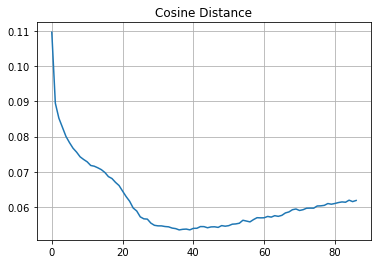

In [19]:
plt.plot(contrastive_history.history["loss"])
plt.grid()
plt.title("Cosine Distance")
plt.show()

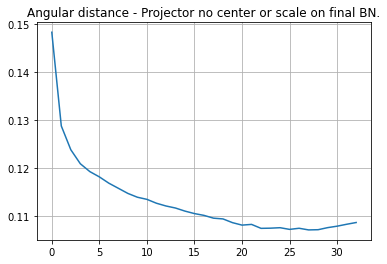

In [167]:
plt.plot(contrastive_history.history["loss"])
plt.grid()
plt.title("Angular distance - Projector no center or scale on final BN.")
plt.show()

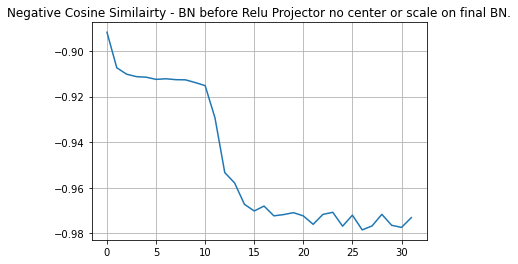

In [149]:
plt.plot(contrastive_history.history["loss"])
plt.grid()
plt.title(
    "Negative Cosine Similairty - BN before Relu Projector no center or scale on final BN."
)
plt.show()

In [156]:
# Early stopping as loss was oscillating, but learned very quickly. Might work better with lower LR.
print("no pretrain", reg_model.evaluate(x_test, y_test))
print("pretrained", model2.evaluate(x_test, y_test))

313/313 [==============================] - 2s 5ms/step - loss: 3.5510 - acc: 0.2998
no pretrain [3.5510411262512207, 0.29980000853538513]
313/313 [==============================] - 2s 5ms/step - loss: 3.2516 - acc: 0.3703
pretrained [3.2515995502471924, 0.3702999949455261]


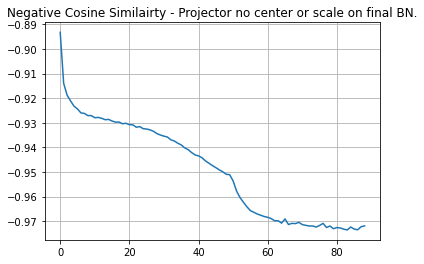

In [108]:
plt.plot(contrastive_history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty - Projector no center or scale on final BN.")
plt.show()

In [115]:
# Negative Cosine Similarity - Projector no center or scale on final BN. 100 examples per class
print("no pretrain", reg_model.evaluate(x_test, y_test))
print("pretrained", model2.evaluate(x_test, y_test))

313/313 [==============================] - 2s 5ms/step - loss: 4.9956 - acc: 0.1669
no pretrain [4.99563455581665, 0.16689999401569366]
313/313 [==============================] - 2s 5ms/step - loss: 4.0802 - acc: 0.2223
pretrained [4.080162525177002, 0.2222999930381775]


In [139]:
# Negative Cosine Similarity - Projector no center or scale on final BN. 2000 examples per class
print("no pretrain", reg_model.evaluate(x_test, y_test))
print("pretrained", model2.evaluate(x_test, y_test))

313/313 [==============================] - 2s 5ms/step - loss: 4.2093 - acc: 0.2090
no pretrain [4.209340572357178, 0.20900000631809235]
313/313 [==============================] - 2s 5ms/step - loss: 3.2375 - acc: 0.3798
pretrained [3.2375073432922363, 0.3797999918460846]


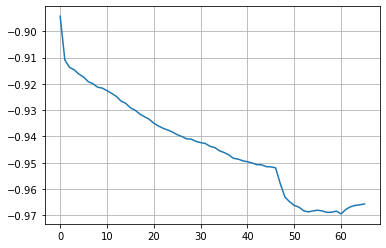

In [86]:
plt.plot(contrastive_history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

In [93]:
# Negative Cosine Similarity
print("no pretrain", reg_model.evaluate(x_test, y_test))
print("pretrained", model2.evaluate(x_test, y_test))

313/313 [==============================] - 2s 5ms/step - loss: 4.6175 - acc: 0.1771
no pretrain [4.617520332336426, 0.17710000276565552]
313/313 [==============================] - 2s 5ms/step - loss: 3.9286 - acc: 0.2409
pretrained [3.9285616874694824, 0.24089999496936798]


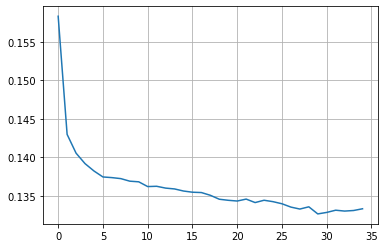

In [37]:
plt.plot(contrastive_history.history["loss"])
plt.grid()
plt.title()
plt.title("Angular Distance")
plt.show()

In [44]:
# Angular distance
print("no pretrain", reg_model.evaluate(x_test, y_test))
print("pretrained", model2.evaluate(x_test, y_test))

313/313 [==============================] - 2s 5ms/step - loss: 4.6792 - acc: 0.1805
no pretrain [4.67922830581665, 0.18050000071525574]
313/313 [==============================] - 2s 5ms/step - loss: 4.4734 - acc: 0.1981
pretrained [4.473399639129639, 0.1981000006198883]


# Distances after 5 epochs

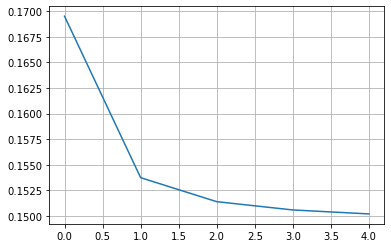

In [19]:
plt.plot(contrastive_history.history["loss"])
plt.grid()
plt.title("Angular Distance")
plt.show()

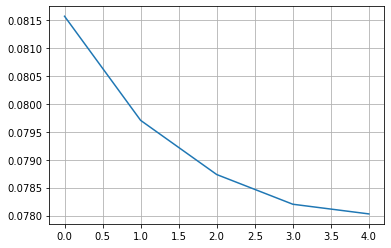

In [29]:
plt.plot(contrastive_history.history["loss"])
plt.grid()
plt.title("Cosine Distance")
plt.show()

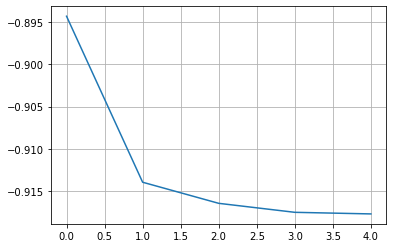

In [25]:
plt.plot(contrastive_history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

# Evaluation

In [168]:
from tensorflow_similarity.samplers import select_examples

# allows to use a fraction of the dataset via select_sample
x_restricted, y_restricted = select_examples(
    x_train, y_raw_train, num_examples_per_class=2000
)
y_restricted = keras.utils.to_categorical(y_restricted, 10)

TEST_EPOCHS = 20
TEST_STEPS_PER_EPOCH = len(x_restricted) // BATCH_SIZE

filtering examples:   0%|          | 0/50000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/20000 [00:00<?, ?it/s]

In [169]:
def get_eval_model(img_size, encoder):
    encoder.trainable = False
    inputs = layers.Input((img_size, img_size, 3))
    x = encoder(inputs, training=False)
    o = layers.Dense(10, activation="softmax")(x)
    model = Model(inputs, o, name="no_pretrain")
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
    return model

# No pretrain

In [170]:
no_pt_encoder = get_encoder(IMG_SIZE)
no_pt_encoder = Model(
    no_pt_encoder.input, no_pt_encoder.get_layer("backbone_pool").output
)
reg_model = get_eval_model(IMG_SIZE, no_pt_encoder)
reg_history = reg_model.fit(
    x_restricted,
    y_restricted,
    batch_size=BATCH_SIZE,
    epochs=TEST_EPOCHS,
    validation_data=(x_test, y_test),
)

Epoch 1/20
157/157 [==============================] - 4s 14ms/step - loss: 8.7656 - acc: 0.1709 - val_loss: 4.3275 - val_acc: 0.2200
Epoch 2/20
157/157 [==============================] - 2s 10ms/step - loss: 4.0877 - acc: 0.2222 - val_loss: 4.1129 - val_acc: 0.2187
Epoch 3/20
157/157 [==============================] - 2s 10ms/step - loss: 3.9311 - acc: 0.2423 - val_loss: 3.8161 - val_acc: 0.2484
Epoch 4/20
157/157 [==============================] - 2s 10ms/step - loss: 3.8550 - acc: 0.2500 - val_loss: 3.6235 - val_acc: 0.2783
Epoch 5/20
157/157 [==============================] - 2s 10ms/step - loss: 3.7284 - acc: 0.2653 - val_loss: 3.8215 - val_acc: 0.2565
Epoch 6/20
157/157 [==============================] - 2s 10ms/step - loss: 3.7544 - acc: 0.2706 - val_loss: 4.1338 - val_acc: 0.1794
Epoch 7/20
157/157 [==============================] - 2s 10ms/step - loss: 3.7352 - acc: 0.2703 - val_loss: 3.6779 - val_acc: 0.2755
Epoch 8/20
157/157 [==============================] - 2s 10ms/step - 

# Pretrained with SiamSiam

In [171]:
contrastive_model.projector.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 2048)]            0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               1048576   
_________________________________________________________________
batch_normalization_178 (Bat (None, 512)               2048      
_________________________________________________________________
dense_38 (Dense)             (None, 2048)              1050624   
Total params: 2,101,248
Trainable params: 2,100,224
Non-trainable params: 1,024
_________________________________________________________________


In [172]:
# Extract the backbone ResNet20.
pt_encoder = Model(
    contrastive_model.get_encoder().input,
    contrastive_model.get_encoder().get_layer("backbone_pool").output,
)
model2 = get_eval_model(IMG_SIZE, pt_encoder)
model2.summary()

Model: "no_pretrain"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
model_10 (Functional)        (None, 256)               568368    
_________________________________________________________________
dense_43 (Dense)             (None, 10)                2570      
Total params: 570,938
Trainable params: 2,570
Non-trainable params: 568,368
_________________________________________________________________


In [173]:
pre_history = model2.fit(
    x_restricted,
    y_restricted,
    batch_size=BATCH_SIZE,
    epochs=TEST_EPOCHS,
    validation_data=(x_test, y_test),
)

Epoch 1/20
157/157 [==============================] - 5s 19ms/step - loss: 5.9568 - acc: 0.1694 - val_loss: 4.2077 - val_acc: 0.1968
Epoch 2/20
157/157 [==============================] - 2s 11ms/step - loss: 3.9105 - acc: 0.2182 - val_loss: 3.8212 - val_acc: 0.2427
Epoch 3/20
157/157 [==============================] - 2s 11ms/step - loss: 3.7634 - acc: 0.2397 - val_loss: 3.8362 - val_acc: 0.2370
Epoch 4/20
157/157 [==============================] - 2s 10ms/step - loss: 3.6854 - acc: 0.2594 - val_loss: 3.7107 - val_acc: 0.2455
Epoch 5/20
157/157 [==============================] - 2s 11ms/step - loss: 3.6102 - acc: 0.2685 - val_loss: 3.6537 - val_acc: 0.2565
Epoch 6/20
157/157 [==============================] - 2s 10ms/step - loss: 3.6299 - acc: 0.2705 - val_loss: 3.6448 - val_acc: 0.2494
Epoch 7/20
157/157 [==============================] - 2s 11ms/step - loss: 3.5708 - acc: 0.2839 - val_loss: 3.7708 - val_acc: 0.2434
Epoch 8/20
157/157 [==============================] - 2s 10ms/step - 

In [174]:
print("no pretrain", reg_model.evaluate(x_test, y_test))
print("pretrained", model2.evaluate(x_test, y_test))

313/313 [==============================] - 2s 5ms/step - loss: 3.5445 - acc: 0.3013
no pretrain [3.544525384902954, 0.3012999892234802]
313/313 [==============================] - 2s 5ms/step - loss: 3.4142 - acc: 0.3173
pretrained [3.414243698120117, 0.3172999918460846]
